# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#method)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem: Finding the best location for a vegan restaurant in Los Angeles <a name="introduction"></a>
A vegan diet is being adopted by more and more people in the USA, and the demand for vegan restaurants is correspondingly increasing. This is particularly true in large multicultural cities such as Los Angeles. 

This capstone project is tailored to stakeholders who are interested in opening a vegan restaurant in Los Angeles.
We want to use data to answer the following question: What is the best location to open a vegan restaurant in LA? 


## Data <a name="data"></a>
Using the Foursquare API (https://developer.foursquare.com/places) we can retrieve information about restaurants in Los Angeles, including location, neighbourhood characteristics (e.g. other venues that are within walking distance), rating, number of tips and type of cuisine. In addition, we will use the Yelp API (https://www.yelp.com/fusion) to find "vegan" venues, because the Foursquare category system only returns a few venues categorized as "vegetarian / vegan", even though there are hundreds according to Yelp or the HappyCow App. 

To map out districts in Los Angeles we can scrape borough names from Wikipedia and use the geocoder python package to find corresponding geospatial coordinates. Using these coordinates we can search on Foursquare and Yelp to find surrounding venues, including vegan restaurants. 

For example, we can search for venues in Hollywood in Los Angeles using the "explore" Foursquare querry and find the surrounding venues and their characteristics. Based on the surrounding area characteristics (e.g. lots of food venues or close proximity to metro stations), we can predict vegan restaurant success as measured by both user ratings and number of likes (suggesting that the restaurant is popular). 

Finally, we can predict the best locations to open a new vegan restaurant based on those area characteristics. 


## Methodology <a name="method"></a>
We will start by scraping Los Angeles neighborhood names from the LA-times website and obtain geospatial coordinates using the geopy package. Following this, we will find vegan venues surrounding these coordinates using the Yelp API. Subsequently, we can find the same venues on Foursquare to obtain rating, pricing, tipping, photo and likes information. We will explore which of these factors are useful to keep for further analysis and combine into a useful "popularity and success" dependent variable. Next, we will predict restaurant "popularity and success" using a k-nearest neighbor algorithm with surrounding venues being used as independent variables (or features). Finally, we can use the trained model to predict the "popularity and success" of new venues based a given location's surroundings. We will do this for illustration purposes for each LA neighborhood center and a pre-specified grid of a subsection of south-west-central LA (exploring all of LA would take a long time...). 

### Import libraries

In [1]:
## import libraries
import requests

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import geocoder # import geocoder to get latitude and longitude
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules + seaborn
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Setup for foursquare API calls

In [2]:
## Define foursquare credentials and version (date)
CLIENT_ID = 'U1ALKNVSQ5OT5GCDQTE3NTUSVQVANLLFPZBOW3BMYR53AG20' # your Foursquare ID
CLIENT_SECRET = '2BGUAXJ14CEJNJQHSWRLNGA5IOJCMBSOAENHD5INTJOHLP45' # your Foursquare Secret
VERSION = '20200120'
LIMIT = 50
categoryID = "4d4b7105d754a06374d81259" # food category
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U1ALKNVSQ5OT5GCDQTE3NTUSVQVANLLFPZBOW3BMYR53AG20
CLIENT_SECRET:2BGUAXJ14CEJNJQHSWRLNGA5IOJCMBSOAENHD5INTJOHLP45


### Step 1: Scrape city data from website to get LA neighborhoods

In [3]:
url = 'https://maps.latimes.com/neighborhoods/neighborhood/list/'
html = requests.get(url).content
df_list = pd.read_html(html)
df_neigh = df_list[0]
df_neigh.to_csv('LA_borough_data.csv')
df_neigh.head()

Name                  Region
0            Acton         Antelope Valley
1  Adams-Normandie              South L.A.
2     Agoura Hills  Santa Monica Mountains
3       Agua Dulce        Northwest County
4         Alhambra      San Gabriel Valley

#### Get latitude and longitude for each borough in LA using the geopy package


In [4]:
addresses = df_neigh['Name'] + ', ' + 'Los Angeles'
latitudes = [None] * len(addresses)
longitudes = [None] * len(addresses)
lost_cities = list()
for i in range(len(addresses)):
    address = addresses[i] # + ', Los Angeles'
    geolocator = Nominatim(user_agent="random_app_name")
    loc = geolocator.geocode(address, timeout=10)
    if loc:
        lat = loc.latitude
        lng = loc.longitude
        latitudes[i] = lat
        longitudes[i] = lng
        if (i % 10 == 0 and i < 100) or i % 100 == 0 or i == (len(addresses)-1):
            print('{}: The geograpical coordinates of {} are {}, {}.'.format(i, address, lat, lng))
    else:
        latitudes[i] = float('NaN')
        longitudes[i] = float('NaN')
        lost_cities.append(address)
        print('The geograpical coordinates of {} are not available.'.format(address))

0: The geograpical coordinates of Acton, Los Angeles are 34.48074149999999, -118.1868378638664.
10: The geograpical coordinates of Arlington Heights, Los Angeles are 34.1281125, -118.1589035.
20: The geograpical coordinates of Bell, Los Angeles are 33.9747806, -118.1866361.
The geograpical coordinates of Beverly Crest, Los Angeles are not available.
The geograpical coordinates of Broadway-Manchester, Los Angeles are not available.
The geograpical coordinates of Castaic Canyons, Los Angeles are not available.
40: The geograpical coordinates of Cerritos, Los Angeles are 33.8644291, -118.0539323.
The geograpical coordinates of Chesterfield Square, Los Angeles are not available.
50: The geograpical coordinates of Compton, Los Angeles are 33.894927, -118.226624.
60: The geograpical coordinates of Downtown, Los Angeles are 34.4987133, -118.5843067.
The geograpical coordinates of Elizabeth Lake, Los Angeles are not available.
80: The geograpical coordinates of Florence-Firestone, Los Angeles 

#### Put geospatial coordinates in dataframe (note that some location querries failed - simply delete those, we still have plenty of neighborhoods to explore)

In [5]:
## New data frame containing all boroughs in LA and their geospatial coordinates
df_neigh['lat'] = latitudes
df_neigh['lng'] = longitudes
df_neigh.head()

Name                  Region        lat         lng
0            Acton         Antelope Valley  34.480741 -118.186838
1  Adams-Normandie              South L.A.  34.033081 -118.297115
2     Agoura Hills  Santa Monica Mountains  34.147910 -118.765704
3       Agua Dulce        Northwest County  34.496382 -118.325635
4         Alhambra      San Gabriel Valley  34.093042 -118.127060

In [6]:
# drop nans from dataframe
df_neigh.dropna(inplace = True)

##### create world map to visualize potentially wrong location data

In [7]:
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, borough in zip(df_neigh['lat'], df_neigh['lng'], df_neigh['Region']):
    label = 'lat={}, lng={}'.format(lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

#### Delete everything outside main LA

In [8]:
region_outside_city = ['Northwest County', 'Antelope Valley', 'Harbor', 'Santa Monica Mountains', 'Angeles Forest']
df_neigh.drop(df_neigh[df_neigh['Region'].isin(region_outside_city)].index, inplace = True)
lowest_lat = 33.7483311
largest_lat = 34.3076252
lowest_lng = -118.645476
largest_lng = -117.7166745
df_neigh.drop(df_neigh[(df_neigh['lat'] < lowest_lat) | (df_neigh['lat'] > largest_lat) | (df_neigh['lng'] < lowest_lng) | (df_neigh['lng'] > largest_lat)].index, inplace = True)

In [9]:
df_neigh.head()

Name              Region        lat         lng
1  Adams-Normandie          South L.A.  34.033081 -118.297115
4         Alhambra  San Gabriel Valley  34.093042 -118.127060
5     Alondra Park           South Bay  33.890134 -118.335133
6         Altadena            Verdugos  34.186316 -118.135233
8          Arcadia  San Gabriel Valley  34.136207 -118.040150

Just in case get rid of any duplicate Names

In [10]:
df_neigh.drop_duplicates(subset="Name", keep="last", inplace=True)
df_neigh.reset_index(drop = True, inplace = True)
len(df_neigh)

207

### Show map of LA neighborhoods

In [12]:
# create map of LA using latitude and longitude values
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df_neigh['lat'], df_neigh['lng'], df_neigh['Name']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

### Let's get vegan restaurants in LA from Yelp (foursquare does not seem to be that great at labelling vegan restaurants...)

Yelp API querry setup

In [16]:
radius = 500

## Yelp API access information
CLIENT_ID_YELP = "3gY1EbFOTv7dL5LoTl3y9A"
API_KEY_YELP = "M6O9t1EBUhPmVHlkXUE3ky-SnKektvQZp-m7C5Kd0WBPgfL7uEz6yBD8xC-Q25EqZ82o9ePSz3iK_roowvc-cSCAVgG0WSTz7Wat8zkM6W0ikSROVxKiQ-CDoGskXnYx"

headers = {'Authorization': 'Bearer %s' % API_KEY_YELP}

# In the dictionary, term can take values like food, cafes or businesses like McDonalds
url = 'https://api.yelp.com/v3/businesses/search'
params = {'term':'vegan food','latitude':df_neigh['lat'][1], 'longitude':df_neigh['lng'][1], 'radius':radius, 'categories':['food'], 'limit': 50}

# Making a get request to the API
req=requests.get(url, params=params, headers=headers)
 
# proceed only if the status code is 200
print('The status code is {}'.format(req.status_code))

The status code is 200


### Create a function that searches for the 50 closest food venues for each neighborhood in LA on Yelp

In [17]:
def getNearbyFoodVenuesYelp(names, latitudes, longitudes, radius=500, categories=['food']):
    
    venues_list=[]
    headers = {'Authorization': 'Bearer %s' % API_KEY_YELP}
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.yelp.com/v3/businesses/search'
        params = {'term':'vegan food','latitude':lat, 'longitude':lng, 'radius':radius, 'categories':categories, 'limit': 50}
            
        # Making a get request to the API
        req=requests.get(url, params=params, headers=headers)
        
        # if successful
        if req.status_code == 200:
            
            # convert data into JSON object
            results = json.loads(req.text)['businesses']
            
            # return only relevant information for each nearby venue
            try: # sometimes "price" category is missing, then simply include empty string
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['id'],
                    v['coordinates']['latitude'], 
                    v['coordinates']['longitude'],  
                    'vegan', 
                    v['rating'], 
                    v['price']) for v in results])
            except:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['id'],
                    v['coordinates']['latitude'], 
                    v['coordinates']['longitude'],  
                    'vegan', 
                    v['rating'], 
                    '') for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category', 
                  'Rating', 
                  'Price tier']
    
    return(nearby_venues)

In [18]:
LA_venues_YELP = getNearbyFoodVenuesYelp(names=df_neigh['Name'], latitudes=df_neigh['lat'], longitudes=df_neigh['lng'])

Adams-Normandie
Alhambra
Alondra Park
Altadena
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bellflower
Bell Gardens
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Burbank
Canoga Park
Carthay
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Diamond Bar
Downey
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy Park
Granada Hills
Griffith Park
Hacienda Heights
Hancock Park
Hansen Dam
Harvard Heights
Hawthorne
Hermosa Beach
Highland Park
Hollywood
Hollywood Hills
Hollywood Hills West
Huntington Park
Hyde Park
Industry
Inglewood
Irw

##### Drop locations that were found multiple times

In [19]:
LA_venues_YELP.drop_duplicates(subset='Venue', keep="first", inplace=True)

### Go through vegan venues found on yelp and see if we can find them also on foursquare. 

This way we can get a consistent cuisine labelling (from foursquare), while the vegan label
comes from Yelp. It is also useful to get foursquare venue IDs to look up details about venues later (e.g. pricing or number of likes).


In [20]:
yelp_venue_category = list()
fs_venue_ids = list()
for name, lat, lng in zip(LA_venues_YELP['Venue'], LA_venues_YELP['Venue Latitude'], LA_venues_YELP['Venue Longitude']):
    print(name)

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        100, 
        1,
        "4d4b7105d754a06374d81259") # only look at food categories

    # make the GET request
    try:
        results = requests.get(url).json()["response"]['venues'][0]
        fs_venue_category =  results['categories'][0]['shortName']       
        fs_venue_id = results['id']
    except:
        fs_venue_category = ""
        fs_venue_id = ""
    #print('-->' + fs_venue_category)
    
    yelp_venue_category.append(fs_venue_category)
    fs_venue_ids.append(fs_venue_id)

Lovebirds Cafe
Alhambra Farmers Market
Sprouts Farmers Market
Bon Appetea Cafe
Robeks
7 Leaves Cafe
Afters Ice Cream
Tastea
Oh Happy Days Natural Food Grocery and Cafe
Tacos 210
Dina's Dumpling
Grocery Outlet Bargain Market
Café de Leche
Chinese Laundry Catering
The Gooey Gourmet
Aldi
LA Paella Catering
GOT PAELLA
Brady's Bakery
Chinese Laundry
GermanYumTruck
The Lobos Truck
Sus Arepas
Roobina's Cake
The Truck Stop
Ozzies Street Tacos
Out West Catering
Chef C's Smhokin Pot
Cítrico Ceviche Bar
Maravilla Latin Cuisine
Tacos La Tehuanita
The Churro Man
Okamoto Kitchen
Good Life Organics
The Bollywood Kitchen
Two Doughs Pizza Co
Teddy's Red Tacos
Chili Chili Mango
Madison Rose Bakery
Tokyo Style Food Truck and Catering
Hungry Belly
Chingón Catering
The Grilled Cheese Truck
The Lime Truck
Lucca Truck
Simply Eggless Bakery - Délicieux
Meccha Matcha
The Cake Korner
Heartland
Pioneer Cash And Carry
Nice Bakery
Lee's Sandwiches
Ambala Sweets & Snacks
99 Ranch Market
GoodFellas Taco Catering
Yog

Sweetness Cakes & Cafe
Punjab Indian Market and Cuisine
Bopomofo Cafe
Mitsuwa Marketplace
Labobatory
Swirlz Creamery
D'ange Bakery
Nomad Ice Pops
Fortune Bakery
Factory Tea Bar
Yama Seafood
Garnish Cafe
Sweet & Savory
Swirlz Soft Serve Parlor
SuperFood Cafe
Backyard Bowls
Kreation Organic Kafe
Sidecar Doughnuts & Coffee
Caffe Luxxe
Holy Grounds at St. Monica
Huckleberry
Planet Smoothie and Tasti D-Lite
Santa Monica Seafood Market & Cafe
John Kelly Chocolates
7-Eleven
India Jones Chow Truck
The Greasy Wiener
Ralph's
Happy Days Cafe
Ubatuba Acai X - Sherman Oaks
Juice Crafters
QWENCH juice bar
Paradis Sherman Oaks
The Dolly Llama
New York Bagel Cafe
Juice Budz
Gelson's
Humphrey Yogart
SanSai Japanese Grill
Syndicate
Evil Cooks
Coffee.jpg
Bean Town
Yogurt & More
Taylor's Ol’ Fashioned Market
Mother Moo Creamery
The Four Seasons Tea Room
Botanica Restaurant & Market
Lamill Coffee Silverlake
Milk
Lucky
barcito
Nimbus Coffee
illy Caffè
Groundwork Coffee
Red Mango
Dogtown Dogs Truck
Grassroot

In [21]:
LA_venues_YELP['Venue Category'] = yelp_venue_category
LA_venues_YELP['FS Venue ID'] = fs_venue_ids

#### What types of vegan food venues did we find?

In [22]:
LA_venues_YELP['Venue Category'].value_counts()

Coffee Shop           107
                       57
Café                   34
Bakery                 27
Mexican                22
Chinese                20
American               17
Food Truck             17
Deli / Bodega          17
Pizza                  16
Fast Food              15
Restaurant             14
Bubble Tea             14
Diner                  14
Asian                  13
Gastropub              13
Ice Cream              12
New American           10
Breakfast              10
Sandwiches              9
Bookstore               9
Italian                 8
Seafood                 8
Donuts                  7
Tacos                   6
Gourmet                 6
Sushi                   6
Burgers                 6
Vegetarian / Vegan      5
Japanese                5
Korean                  5
Supermarket             5
Mediterranean           5
BBQ                     5
Vietnamese              4
German                  4
Indonesian              4
Indian                  3
Grocery Stor

#### Not all of those make a lot of sense, kick out some questionable categories

In [23]:
categories_to_kick_out = ["Park", "Mall", "Halal", "Food Stand", "Farmer's Market", "Food", "Donuts", "Deli / Bodega", "Arcade", "Hot Dogs", "Entertainment", "Sports Bar", "Bar", "Gas Station", "Bookstore", "Yogurt", "Fried Chicken", 
                          "Brewery", "Pharmacy", "Desserts", "Grocery Store", "Cineplex", "Juice Bar", "Steakhouse", "Ice Cream", "Supermarket", "Bubble Tea", "Bakery"]

In [24]:
indexNames = LA_venues_YELP[ LA_venues_YELP['Venue Category'].isin(categories_to_kick_out) ].index
print(indexNames)
# Delete these row indexes from dataFrame
LA_venues_YELP.drop(indexNames , inplace=True)

Int64Index([   7,    9,   13,   14,   18,   20,   28,   29,   34,   38,
            ...
            1910, 1934, 1937, 1946, 1959, 2011, 2014, 2030, 2085, 2138],
           dtype='int64', length=164)


Cafes and coffee shops are the same, label them the same, too!

In [25]:
LA_venues_YELP['Venue Category'][LA_venues_YELP['Venue Category'] == 'Café'] = 'Coffee Shop'

C:\Users\sbuer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
LA_venues_YELP['Venue Category'].value_counts()

Coffee Shop           141
Mexican                22
Chinese                20
American               17
Food Truck             17
Pizza                  16
Fast Food              15
Restaurant             14
Diner                  14
Asian                  13
Gastropub              13
Breakfast              10
New American           10
Sandwiches              9
Seafood                 8
Italian                 8
Donuts                  7
Sushi                   6
Gourmet                 6
Tacos                   6
Burgers                 6
Korean                  5
Vegetarian / Vegan      5
Japanese                5
BBQ                     5
Mediterranean           5
German                  4
Indonesian              4
Vietnamese              4
Indian                  3
Dim Sum                 3
Food Court              3
Taiwanese               3
Bagels                  3
Food                    3
Irish                   2
Snacks                  2
Caribbean               2
French      

Delete additional categories of little to no interest for opening a vegan restaurant 

In [27]:
supermarkets = ["7-Eleven", "Aldi"]
LA_venues_YELP.drop(LA_venues_YELP[LA_venues_YELP['Venue'].isin(supermarkets)].index, inplace=True)

How many vegan venues are there per neighborhood?

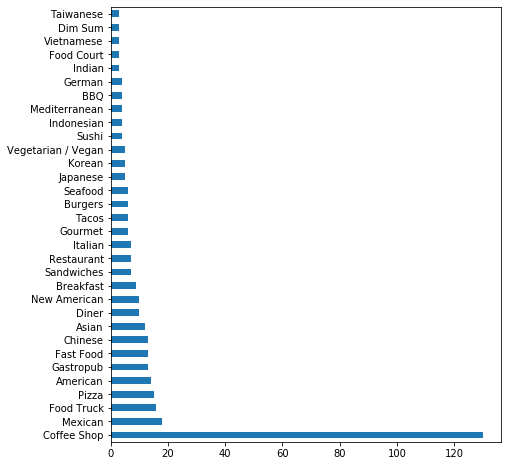

In [702]:
## Plot number of restaurants of a given category (summarize restaurants with less than 3 as "other")
LA_venues_YELP['Venue Category'].value_counts()[LA_venues_YELP['Venue Category'].value_counts()>2].plot(kind='barh', figsize=(7, 8))

In [28]:
venue_counts_yelp = LA_venues_YELP.groupby('Neighborhood').count()
venue_counts_yelp.head()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                            
Alhambra                             7                       7      7   
Altadena                            14                      14     14   
Arleta                               8                       8      8   
Artesia                             23                      23     23   
Atwater Village                      2                       2      2   

                 Venue ID  Venue Latitude  Venue Longitude  Venue Category  \
Neighborhood                                                                 
Alhambra                7               7                7               7   
Altadena               14              14               14              14   
Arleta                  8               8                8               8   
Artesia                23              23               23              23   
Atwater Village         2               2                2               2   

                 Rating  Price tier  FS Venue ID  
Neighborhood                                      
Alhambra              7           7            7  
Altadena             14          14           14  
Arleta                8           8            8  
Artesia              23          23           23  
Atwater Village       2           2            2

#### Visualize Yelp vegan restaurant data

In [29]:
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(LA_venues_YELP['Venue Latitude'], LA_venues_YELP['Venue Longitude'], LA_venues_YELP['Venue']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

#### Set boundaries for vegan venues - only those in LA are of interest!

In [30]:
print(df_neigh.lng[df_neigh['Name']=="Pacific Palisades"])
print(df_neigh.lng[df_neigh['Name']=="Glendora"])
print(df_neigh.lat[df_neigh['Name']=="San Fernando"])
print(df_neigh.lat[df_neigh['Name']=="Bellflower"])

123   -118.540955
Name: lng, dtype: float64
67   -117.865339
Name: lng, dtype: float64
146    34.28497
Name: lat, dtype: float64
16    33.88257
Name: lat, dtype: float64


In [31]:
## Create a backup of the LA_venues_YELP dataframe
YELP_bu = LA_venues_YELP

In [32]:
## Delete Yelp restaurants outside LA (Yelp increases the radius up to 25km to fill up the 50 requested return slots)
lowest_lat = 33.88257
largest_lat = 34.28497
lowest_lng = -118.540955
largest_lng = -117.865339
LA_venues_YELP.drop(LA_venues_YELP[(LA_venues_YELP['Venue Latitude'] < lowest_lat) | 
                                   (LA_venues_YELP['Venue Latitude'] > largest_lat) | 
                                   (LA_venues_YELP['Venue Longitude'] < lowest_lng) | 
                                   (LA_venues_YELP['Venue Longitude'] > largest_lng)
                                  ].index, inplace = True)

### Visualize Yelp vegan restaurants in "main" LA

In [33]:
latitude = 34.0330812
longitude = -118.204865
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(LA_venues_YELP['Venue Latitude'], LA_venues_YELP['Venue Longitude'], LA_venues_YELP['Venue']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

In [34]:
LA_venues_YELP.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Alhambra              34.093042              -118.12706   
1     Alhambra              34.093042              -118.12706   
2     Alhambra              34.093042              -118.12706   
3     Alhambra              34.093042              -118.12706   
4     Alhambra              34.093042              -118.12706   

                     Venue                Venue ID  Venue Latitude  \
0           Lovebirds Cafe  0KeC2ioM5HM4VOHimzQrlA       34.094326   
1  Alhambra Farmers Market  K2Lf7yWTll38m-r-A_7ohw       34.093122   
2   Sprouts Farmers Market  -tX_rTfxcCV0dhx0hge6DA       34.095342   
3         Bon Appetea Cafe  2xOKFfMqj3WRrxwZUJNRlw       34.093921   
4                   Robeks  0qeuPidgfBedF4DOcYoQ4w       34.095222   

   Venue Longitude Venue Category  Rating Price tier               FS Venue ID  
0      -118.127487      Taiwanese     4.0          $  5d60a20dbde37a0008c34bca  
1      -118.128167    Coffee Shop     4.0         $$  53bb56c3498e1eb378326cae  
2      -118.125038        Burgers     3.5         $$  55fc485d498e81836932d7fe  
3      -118.128958      Taiwanese     4.0          $  5d60a20dbde37a0008c34bca  
4      -118.127198    Coffee Shop     3.5          $  4aca3687f964a520e4c020e3

create a new dataframe name to use from here onwards

In [36]:
LA_vegan_venues = LA_venues_YELP
LA_vegan_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Alhambra              34.093042              -118.12706   
1     Alhambra              34.093042              -118.12706   
2     Alhambra              34.093042              -118.12706   
3     Alhambra              34.093042              -118.12706   
4     Alhambra              34.093042              -118.12706   

                     Venue                Venue ID  Venue Latitude  \
0           Lovebirds Cafe  0KeC2ioM5HM4VOHimzQrlA       34.094326   
1  Alhambra Farmers Market  K2Lf7yWTll38m-r-A_7ohw       34.093122   
2   Sprouts Farmers Market  -tX_rTfxcCV0dhx0hge6DA       34.095342   
3         Bon Appetea Cafe  2xOKFfMqj3WRrxwZUJNRlw       34.093921   
4                   Robeks  0qeuPidgfBedF4DOcYoQ4w       34.095222   

   Venue Longitude Venue Category  Rating Price tier               FS Venue ID  
0      -118.127487      Taiwanese     4.0          $  5d60a20dbde37a0008c34bca  
1      -118.128167    Coffee Shop     4.0         $$  53bb56c3498e1eb378326cae  
2      -118.125038        Burgers     3.5         $$  55fc485d498e81836932d7fe  
3      -118.128958      Taiwanese     4.0          $  5d60a20dbde37a0008c34bca  
4      -118.127198    Coffee Shop     3.5          $  4aca3687f964a520e4c020e3

### Explore vegan restaurant ratings

In [37]:
## Treating all vegan restaurants equally for now, let's explore ratings ... 
# create map 
latitude = 34.0330812
longitude = -118.204865
map_LA_veg_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
df = LA_vegan_venues
for lat, lng, venue, rating in zip(df['Venue Latitude'], df['Venue Longitude'], df['Venue'], df['Rating']):
    if rating > 4.5:
        cur_col = 'green'
    elif rating >= 4.5:
        cur_col = '#73cd32'#cdb332
    elif rating >= 4:
        cur_col = '#9acd32'
    elif rating >= 3.5:
        cur_col = '#c1cd32'
    elif rating >= 3:
        cur_col = 'orange'
    else:
        cur_col = 'red'
    label = '{}'.format(venue)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=folium.Popup(label, parse_html=True),
        color=cur_col,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_veg_venues)  
    
map_LA_veg_venues

#### What food categories are particulary popular/highly rated?

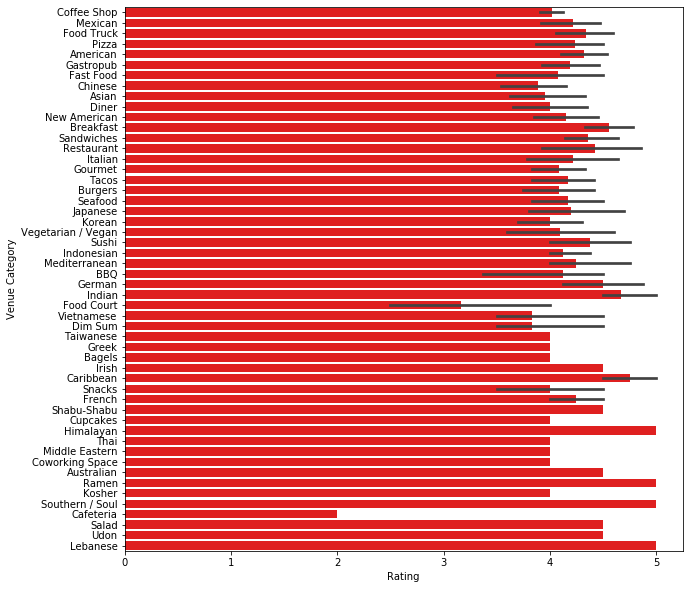

In [39]:
plt.figure(figsize=(10,10))
sns.barplot(
    data=LA_vegan_venues,
    x="Rating", 
    y="Venue Category",
    color='red', 
    order=LA_vegan_venues['Venue Category'].value_counts().index)

### For each vegan restaurant get pricing, likes, photos, tips and rating (if they exists on Foursquare)

In [40]:
like_list = list()
price_list = list()
photos_list = list()
tips_list = list()
rating_list = list()

for irest in range(len(LA_vegan_venues['FS Venue ID'])):

    venue_id = LA_vegan_venues['FS Venue ID'][LA_vegan_venues['FS Venue ID'].index[irest]]
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/'+venue_id+'?/&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)

    # make the GET request
    result = requests.get(url).json()["response"]    

    # Get likes and pricing (if available), otherwise append empty list
    likes = []
    price = []
    photos = []
    tips = []
    rating = []
    if len(result) != 0: # if result is empty do nothing
        try:
            likes = result['venue']['likes']['count']
        except:
            ""
        try:
            price = result['venue']['price']['tier']
        except:
            ""
        try:
            photos = result['venue']['photos']['count'] 
        except:
            ""
        try:
            tips = result['venue']['tips']['count'] 
        except:
            ""
        try:
            rating = result['venue']['rating'] 
        except:
            ""
        
    like_list.append(likes)
    price_list.append(price)
    photos_list.append(photos)
    tips_list.append(tips)
    rating_list.append(rating)

In [41]:
LA_vegan_venues.shape

(394, 11)

In [42]:
len(like_list)

394

In [43]:
LA_vegan_venues['Price FS'] = price_list
LA_vegan_venues['Likes FS'] = like_list
LA_vegan_venues['Photos FS'] = photos_list
LA_vegan_venues['Tips FS'] = tips_list
LA_vegan_venues['Rating FS'] = rating_list

##### Replace empty list elements with NaNs

In [671]:
LA_vegan_venues.mask(LA_vegan_venues.applymap(str).eq('[]'), inplace=True)

In [672]:
LA_vegan_venues[["Rating", "Rating FS", "Price FS", "Likes FS", "Tips FS", "Photos FS"]].head(10)

Rating Rating FS Price FS  Likes FS  Tips FS  Photos FS
0      4.0       8.2      NaN         2        1         16
1      4.0       7.4        1        40       20         90
2      3.5       7.6        1        22        4         27
3      4.0       8.2      NaN         2        1         16
4      3.5       7.3        1        47       20         61
5      4.0         8        1        18        2         44
6      4.0       8.2      NaN         2        1         16
8      4.5       8.2        1         4        2          5
10     4.0       8.2      NaN         0        1          1
11     4.0       8.2        1         4        2          5

### Explore correlations between variables 

In [673]:
corr_matrix = LA_vegan_venues[["Rating", "Rating FS", "Price FS", "Likes FS", "Tips FS", "Photos FS"]].apply(pd.to_numeric).corr(method="spearman")
corr_matrix.style.background_gradient(cmap='coolwarm')

Likes tips and photos are almost perfectly correlated, so I can just keep one of them.
However, Rating and Rating FS are hardly correlated at all, which is surprising. I will stick with only Foursquare information for now.  

#### Plot distributions of variables (rating, likes, etc.)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'log(Likes FS + 0.5)')]

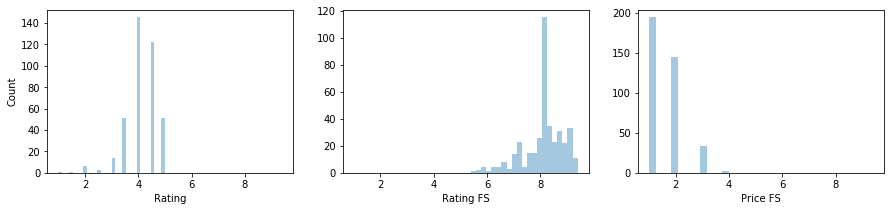

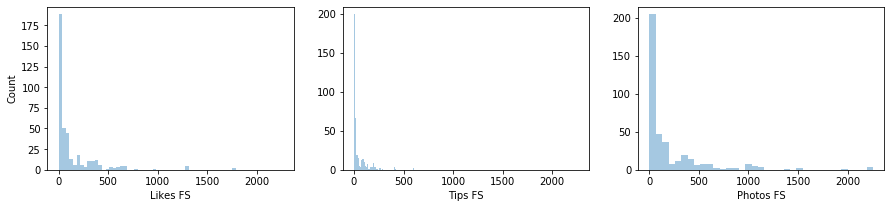

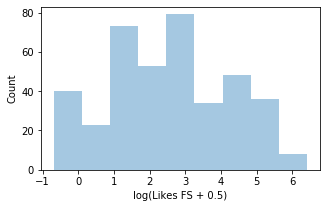

In [674]:
## Is restaurant rating related to surroundings? If so which ones?
## Show pricing by category
fig,a = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
sns.distplot(LA_vegan_venues['Rating'], kde=False, ax=a[0]);
sns.distplot(LA_vegan_venues['Rating FS'], kde=False, ax=a[1]);
sns.distplot(LA_vegan_venues['Price FS'][LA_vegan_venues['Price FS'].notnull()], kde=False, ax=a[2]);
a[0].set(ylabel='Count')
fig2,a2 = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
sns.distplot(LA_vegan_venues['Likes FS'], kde=False, ax=a2[0]);
sns.distplot(LA_vegan_venues['Tips FS'], kde=False, ax=a2[1]);
sns.distplot(LA_vegan_venues['Photos FS'], kde=False, ax=a2[2]);
a2[0].set(ylabel='Count')
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(np.log(LA_vegan_venues['Tips FS']+0.5), kde=False);
a3.set(xlabel='log(Likes FS + 0.5)', ylabel='Count')

We want to open a restaurant that is popular and successful, which we might quantify by having a high rating, as well as many tips. Because the range of values for likes and rating are so different, we swill first put them in a similar scale and then simply add them up to create our variable of restaurant success. We also need to substitute ratings that are unavailable on FS (let's use the median rating overall)

In [49]:
LA_vegan_venues['Rating FS'][LA_vegan_venues['Rating FS'].isnull()] = np.median(LA_vegan_venues['Rating FS'][LA_vegan_venues['Rating FS'].notnull()])

C:\Users\sbuer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
LA_vegan_venues["success"] = 0.5 * ( (np.log(LA_vegan_venues['Tips FS']+1) / max(np.log(LA_vegan_venues['Tips FS']+1))) + (LA_vegan_venues['Rating FS'] / 10) )

#### Show "success" distribution

[Text(0, 0.5, 'Count')]

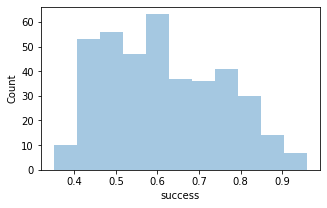

In [52]:
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(LA_vegan_venues['success'], kde=False);
a3.set(ylabel='Count')

### What food categories are particulary popular/highly rated?

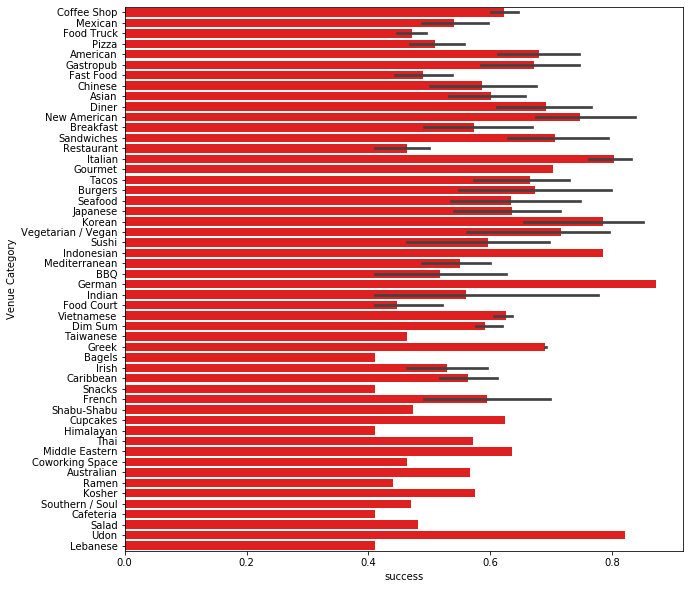

In [53]:
plt.figure(figsize=(10,10))
sns.barplot(
    data=LA_vegan_venues,
    x="success", 
    y="Venue Category",
    color='red', 
    order=LA_vegan_venues['Venue Category'].value_counts().index)

### Treating the vegan venues as "neighborhoods", we can look on foursquare to find adjacent Venues in a 200 meter radius and then use k-nearest neighbors regression to find the best surroundings for successful venues

In [54]:
## Relevant venue categories
fs_categories = {
    'Food': '4d4b7105d754a06374d81259',
    'Shop & Service': '4d4b7105d754a06378d81259',
    'Bus Stop': '52f2ab2ebcbc57f1066b8b4f',
    'Metro Station': '4bf58dd8d48988d1fd931735',
    'Nightlife Spot': '4d4b7105d754a06376d81259',
    'Arts & Entertainment': '4d4b7104d754a06370d81259'
}
fs_category_labels = ["Food", "Shop & Service", "Bus Stop", "Metro Station", "Nightlife Spot", "Arts & Entertainment"]

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        for icat in range(len(fs_category_labels)):

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                fs_categories[fs_category_labels[icat]])

            # make the GET request
            try: 
                results = requests.get(url).json()["response"]['venues']

                # return only relevant information for each nearby venue
                for v in results:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['id'],
                        v['location']['lat'], 
                        v['location']['lng'],  
                        v['categories'][0]['shortName'], 
                        fs_category_labels[icat])])
            except:
                print("Exception occured - could not read information from Foursquare")
                
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category Detailed', 
                  'Venue Category']

    return(nearby_venues)

In [60]:
surrounding_venues = getNearbyVenues(LA_vegan_venues["Venue"], LA_vegan_venues["Venue Latitude"], LA_vegan_venues["Venue Longitude"])

Lovebirds Cafe
Alhambra Farmers Market
Sprouts Farmers Market
Bon Appetea Cafe
Robeks
7 Leaves Cafe
Afters Ice Cream
Oh Happy Days Natural Food Grocery and Cafe
Dina's Dumpling
Grocery Outlet Bargain Market
Café de Leche
LA Paella Catering
GOT PAELLA
Chinese Laundry
The Lobos Truck
Sus Arepas
Roobina's Cake
The Truck Stop
Chef C's Smhokin Pot
Tacos La Tehuanita
The Churro Man
Okamoto Kitchen
The Bollywood Kitchen
Teddy's Red Tacos
Tokyo Style Food Truck and Catering
Hungry Belly
Chingón Catering
The Falafel Factory
Urban Espresso
Pinch of Flavor
Baby's Badass Burgers
Delmy's Pupusas
Atwater Village Farmers' Market
Yureka Boba & Tea House
Congregation Ale House
Mantra Coffee & BnB
Smart & Final Extra!
King Donut
Acai Joint
Cevicheria Las Olas
Habibi Yalla
Mix Bowl Heroes
La Kubanita
Billionaire Burger Boyz
The F Truck
Poutine Brothers
Fries First
Kings Wings
Amazebowls
Ortiz kitchen on the Street
Los Angeles Shave Ice Truck
Wicked Fish Tacos
Wing Society
Richeeze
Big Green Bowl
Roni Mac

##### Note that the venues themselves will be included in the output. I will leave those in, because even though being close to oneself is not very informative, being close to one of the other vegan restaurants might well be!

In [61]:
surrounding_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Lovebirds Cafe              34.094326             -118.127487   
1  Lovebirds Cafe              34.094326             -118.127487   
2  Lovebirds Cafe              34.094326             -118.127487   
3  Lovebirds Cafe              34.094326             -118.127487   
4  Lovebirds Cafe              34.094326             -118.127487   

                            Venue                  Venue ID  Venue Latitude  \
0        Love Birds Cafe & Bakery  4a96fc37f964a520d72720e3       34.094307   
1            Gen Korean BBQ House  50dd1021e4b04eb763143b28       34.094575   
2                       Starbucks  4aca3687f964a520e4c020e3       34.094775   
3  38 Degrees Ale House and Grill  4af39c5cf964a520eeee21e3       34.094512   
4                Afters Ice Cream  58e1c7b4ca107022094178b9       34.094715   

   Venue Longitude Venue Category Detailed Venue Category  
0      -118.127587                  Bakery           Food  
1      -118.127879                  Korean           Food  
2      -118.128113             Coffee Shop           Food  
3      -118.127912               Gastropub           Food  
4      -118.127563               Ice Cream           Food

#### Do one hot encoding for different venue types

In [206]:
# one hot encoding of venue categories by neighborhood
# LA_onehot = pd.get_dummies(surrounding_venues[['Venue Category']], prefix="", prefix_sep="")
LA_onehot = pd.get_dummies(surrounding_venues[['Venue Category Detailed']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Vegan Venue'] = surrounding_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

Vegan Venue  ATM  Academic Building  Accessories  Acupuncturist  \
0  Lovebirds Cafe    0                  0            0              0   
1  Lovebirds Cafe    0                  0            0              0   
2  Lovebirds Cafe    0                  0            0              0   
3  Lovebirds Cafe    0                  0            0              0   
4  Lovebirds Cafe    0                  0            0              0   

   Administrative Building  Adult Boutique  African  American  Amphitheater  \
0                        0               0        0         0             0   
1                        0               0        0         0             0   
2                        0               0        0         0             0   
3                        0               0        0         0             0   
4                        0               0        0         0             0   

   Antiques  Apparel  Arcade  Arepas  Argentinian  Art Gallery  Art Museum  \
0         0        0       0       0            0            0           0   
1         0        0       0       0            0            0           0   
2         0        0       0       0            0            0           0   
3         0        0       0       0            0            0           0   
4         0        0       0       0            0            0           0   

   Art Studio  Arts  Arts & Crafts  Arts & Entertainment  Asian  \
0           0     0              0                     0      0   
1           0     0              0                     0      0   
2           0     0              0                     0      0   
3           0     0              0                     0      0   
4           0     0              0                     0      0   

   Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
0                0           0           0            0            0   
1                0           0           0            0            0   
2                0           0           0            0            0   
3                0           0           0            0            0   
4                0           0           0            0            0   

   Auto Workshop  Automotive  BBQ  Baby Store  Bagels  Bakery  Bank  Bar  \
0              0           0    0           0       0       1     0    0   
1              0           0    0           0       0       0     0    0   
2              0           0    0           0       0       0     0    0   
3              0           0    0           0       0       0     0    0   
4              0           0    0           0       0       0     0    0   

   Basketball  Beach Bar  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0           0          0         0            0           0             0   
1           0          0         0            0           0             0   
2           0          0         0            0           0             0   
3           0          0         0            0           0             0   
4           0          0         0            0           0             0   

   Big Box Store  Bike Shop  Billiards  Bistro  Board Shop  Bookstore  \
0              0          0          0       0           0          0   
1              0          0          0       0           0          0   
2              0          0          0       0           0          0   
3              0          0          0       0           0          0   
4              0          0          0       0           0          0   

   Boutique  Bowling Alley  Brazilian  Breakfast  Brewery  Bridal  Bubble Tea  \
0         0              0          0          0        0       0           0   
1         0              0          0          0        0       0           0   
2         0              0          0          0        0       0           0   
3         0              0          0          0        0       0           0   
4         0            

In [337]:
## Data frame showing relative prevalence of venue type by neighborhood
LA_ratio = LA_onehot.groupby('Vegan Venue').mean().reset_index()
LA_ratio.head()

Vegan Venue  ATM  Academic Building  Accessories  Acupuncturist  \
0     1802 Roasters  0.0                0.0          0.0            0.0   
1     7 Leaves Cafe  0.0                0.0          0.0            0.0   
2  85°C Bakery Cafe  0.0                0.0          0.0            0.0   
3      A Divine H2O  0.0                0.0          0.0            0.0   
4  ACASA Food Truck  0.0                0.0          0.0            0.0   

   Administrative Building  Adult Boutique  African  American  Amphitheater  \
0                      0.0             0.0      0.0  0.000000           0.0   
1                      0.0             0.0      0.0  0.012658           0.0   
2                      0.0             0.0      0.0  0.000000           0.0   
3                      0.0             0.0      0.0  0.000000           0.0   
4                      0.0             0.0      0.0  0.000000           0.0   

   Antiques   Apparel    Arcade  Arepas  Argentinian  Art Gallery  Art Museum  \
0       0.0  0.000000  0.000000     0.0          0.0     0.083333         0.0   
1       0.0  0.025316  0.012658     0.0          0.0     0.000000         0.0   
2       0.0  0.000000  0.007752     0.0          0.0     0.007752         0.0   
3       0.0  0.034091  0.000000     0.0          0.0     0.045455         0.0   
4       0.0  0.000000  0.000000     0.0          0.0     0.000000         0.0   

   Art Studio  Arts  Arts & Crafts  Arts & Entertainment     Asian  \
0         0.0   0.0       0.000000              0.000000  0.000000   
1         0.0   0.0       0.000000              0.000000  0.012658   
2         0.0   0.0       0.007752              0.007752  0.007752   
3         0.0   0.0       0.000000              0.000000  0.011364   
4         0.0   0.0       0.000000              0.000000  0.000000   

   Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
0              0.0         0.0         0.0          0.0          0.0   
1              0.0         0.0         0.0          0.0          0.0   
2              0.0         0.0         0.0          0.0          0.0   
3              0.0         0.0         0.0          0.0          0.0   
4              0.0         0.0         0.0          0.0          0.0   

   Auto Workshop  Automotive       BBQ  Baby Store  Bagels    Bakery  \
0            0.0         0.0  0.000000         0.0     0.0  0.000000   
1            0.0         0.0  0.012658         0.0     0.0  0.037975   
2            0.0         0.0  0.000000         0.0     0.0  0.015504   
3            0.0         0.0  0.000000         0.0     0.0  0.000000   
4            0.0         0.0  0.000000         0.0     0.0  0.000000   

       Bank       Bar  Basketball  Beach Bar  Beer Bar  Beer Garden  \
0  0.000000  0.000000         0.0        0.0       0.0     0.000000   
1  0.000000  0.025316         0.0        0.0       0.0     0.012658   
2  0.023256  0.077519         0.0        0.0       0.0     0.007752   
3  0.000000  0.022727         0.0        0.0       0.0     0.000000   
4  0.000000  0.250000         0.0        0.0       0.0     0.000000   

   Beer Store  Betting Shop  Big Box Store  Bike Shop  Billiards  Bistro  \
0         0.0           0.0            0.0        0.0   0.000000     0.0   
1         0.0           0.0            0.0        0.0   0.000000     0.0   
2         0.0           0.0            0.0        0.0   0.007752     0.0   
3         0.0           0.0            0.0        0.0   0.000000     0.0   
4         0.0           0.0            0.0        0.0   0.000000     0.0   

   Board Shop  Bookstore  Boutique  Bowling Alley  Brazilian  Breakfast  \
0         0.0   0.000000  0.000000            0.0        0.0        0.0   
1         0.0   0.000000  0.025316            0.0        0.0        0.0   
2         0.0   0.007752  0.007752            0.0        0.0        0.0   
3         0.0   0.011364  0.000000            0.0        0.0        0.0   
4         0.0   0.000000  0.000000            0.0

#### Feature selection

Simply leave in all features for now.

### Prepare data for k-nearest-neighbor regressor

In [271]:
## Features (independent variables)
X = LA_ratio.drop("Vegan Venue", axis=1)

## And dependent variable (restaurant success / popularity)
y = LA_vegan_venues['success'].astype('float')

#### Divide data into training and test set

In [272]:
from sklearn.model_selection import train_test_split

# divide data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

# this last bit is just to check whether I get the same answer with the standardscaler method (see below)
X_test_z_manual = (X_test - X_train.mean()) / np.std(X_train)
X_test_z_manual[0:5]

ATM  Academic Building  Accessories  Acupuncturist  \
127 -0.195647           -0.06178    -0.327555      -0.084399   
124 -0.195647           -0.06178    -0.327555      -0.084399   
246 -0.195647           -0.06178    -0.327555      -0.084399   
182 -0.195647           -0.06178    -0.327555      -0.084399   
327 -0.195647           -0.06178    -0.327555      -0.084399   

     Administrative Building  Adult Boutique   African  American  \
127                      NaN       -0.107279 -0.086309 -0.749869   
124                      NaN       -0.107279 -0.086309  0.116519   
246                      NaN       -0.107279 -0.086309  1.606705   
182                      NaN       -0.107279 -0.086309  0.383099   
327                      NaN       -0.107279 -0.086309  0.000632   

     Amphitheater  Antiques   Apparel    Arcade  Arepas  Argentinian  \
127      -0.08741 -0.317281 -0.534809 -0.380671     NaN    -0.160515   
124      -0.08741 -0.317281 -0.534809 -0.380671     NaN     5.517753   
246      -0.08741 -0.317281 -0.534809 -0.380671     NaN    -0.160515   
182      -0.08741 -0.317281 -0.534809 -0.380671     NaN    -0.160515   
327      -0.08741  0.612353  0.221677  0.420259     NaN    -0.160515   

     Art Gallery  Art Museum  Art Studio  Arts  Arts & Crafts  \
127    -0.649890   -0.263515   -0.124262   NaN      -0.437088   
124    -0.649890   -0.263515   -0.124262   NaN      -0.437088   
246    -0.649890   -0.263515   -0.124262   NaN       3.294549   
182     0.947256   -0.263515   -0.124262   NaN       1.356968   
327     0.584422   -0.263515   -0.124262   NaN       0.157121   

     Arts & Entertainment     Asian  Assisted Living  Astrologer  Australian  \
127             -0.216852 -0.576480         -0.06178   -0.121059         inf   
124             -0.216852  0.724749         -0.06178   -0.121059         NaN   
246             -0.216852 -0.576480         -0.06178   -0.121059         NaN   
182              1.240008 -0.576480         -0.06178   -0.121059         NaN   
327             -0.216852 -0.576480         -0.06178   -0.121059         NaN   

     Auto Dealer  Auto Garage  Auto Workshop  Automotive       BBQ  \
127    -0.203092    -0.125265      -0.145067    1.128497 -0.306248   
124    -0.203092    -0.125265      -0.145067    4.160621 -0.306248   
246    -0.203092    -0.125265      -0.145067   -0.482319 -0.306248   
182    -0.203092     3.372991      -0.145067   -0.482319 -0.306248   
327    -0.203092    -0.125265      -0.145067   -0.482319 -0.306248   

     Baby Store    Bagels    Bakery      Bank       Bar  Basketball  \
127   -0.163063 -0.301454 -0.726838 -0.706774 -0.746248   -0.087534   
124   -0.163063 -0.301454  0.789555 -0.706774 -0.746248   -0.087534   
246   -0.163063 -0.301454 -0.726838 -0.706774 -0.746248   -0.087534   
182   -0.163063 -0.301454  0.264650 -0.286153 -0.250898   -0.087534   
327   -0.163063 -0.301454 -0.070057 -0.428146  2.535052   -0.087534   

     Beach Bar  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
127   -0.15268 -0.164524    -0.292075   -0.148065      -0.06178   
124   -0.15268 -0.164524    -0.292075   -0.148065      -0.06178   
246   -0.15268 -0.164524    -0.292075   -0.148065      -0.06178   
182   -0.15268 -0.164524    -0.292075   -0.148065      -0.06178   
327   -0.15268 -0.164524     1.983029   -0.148065      -0.06178   

     Big Box Store  Bike Shop  Billiards    Bistro  Board Shop  Bookstore  \
127      -0.078544  -0.423229  -0.214374 -0.139082   -0.105217  -0.532694   
124      -0.078544  -0.423229  -0.214374 -0.139082   -0.105217  -0.532694   
246      -0.078544  -0.423229  -0.214374 -0.139082   -0.105217  -0.532694   
182      -0.078544  -0.423229  -0.214374 -0.139082   -0.105217  -0.532694   
327      -0.078544  -0.423229   4.061652 -0.139082   -0.105217  -0.532694   

     Boutique  Bowling Alley  Brazilian  Breakfast   Brewery    Bridal  \
127 -0.712149       -0.16664  -0.191393  -0.285071 -0.199283 -0.399385   
124 -0.712149       -0.16664  -0.191393  -0.28507

standardize data

In [273]:
Xz_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
Xz_test = preprocessing.StandardScaler().fit(X_train).transform(X_test)
Xz_test[0:5]

array([[-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
         1.64317456, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021]])

### K-nearest neighbor regression

In [274]:
## get required package
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 

rmse_val = [] #to store rmse values for different k
Nk = 20
for K in range(Nk):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(Xz_train, y_train)  #fit the model
    pred=model.predict(Xz_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.2102088967754527
RMSE value for k=  2 is: 0.18500955409019804
RMSE value for k=  3 is: 0.17522248320895706
RMSE value for k=  4 is: 0.1669907684192794
RMSE value for k=  5 is: 0.16270331836195187
RMSE value for k=  6 is: 0.1615380210355482
RMSE value for k=  7 is: 0.15914987185780854
RMSE value for k=  8 is: 0.1566752262214264
RMSE value for k=  9 is: 0.1549054937849159
RMSE value for k=  10 is: 0.15272836582666646
RMSE value for k=  11 is: 0.1550126359758407
RMSE value for k=  12 is: 0.15609375964333905
RMSE value for k=  13 is: 0.15532927593896584
RMSE value for k=  14 is: 0.15287487510854653
RMSE value for k=  15 is: 0.15094918516138126
RMSE value for k=  16 is: 0.1502392447218776
RMSE value for k=  17 is: 0.14991728130651674
RMSE value for k=  18 is: 0.14908207414459648
RMSE value for k=  19 is: 0.14840580812068047
RMSE value for k=  20 is: 0.14798860403924172


#### Visualize decoding performance (RMSE)


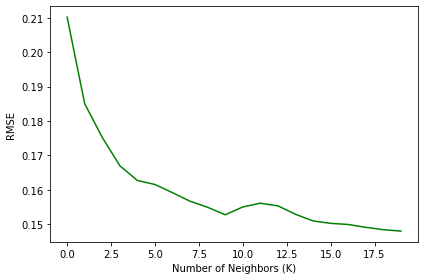

In [275]:
plt.plot(range(Nk),rmse_val,'g')
plt.ylabel('RMSE ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

A value of K = 9 seems reasonable

#### We can now finally go through the different neighborhoods of LA and predict vegan restaurant success based on its characteristics

For each neighborhood, obtain the surrounding venues in a 200 m radius (as we did before centered on the restaurants). In principle this can be done with any specific location, but for now we just want to have a rough idea of which neighborhoods are suitable for opening a vegan restaurant.

In [224]:
LA_neigh_venues = getNearbyVenues(df_neigh["Name"], df_neigh["lat"], df_neigh["lng"])

Adams-Normandie
Alhambra
Alondra Park
Altadena
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bellflower
Bell Gardens
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Burbank
Canoga Park
Carthay
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Diamond Bar
Downey
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy Park
Granada Hills
Griffith Park
Hacienda Heights
Hancock Park
Hansen Dam
Harvard Heights
Hawthorne
Hermosa Beach
Highland Park
Hollywood
Hollywood Hills
Hollywood Hills West
Huntington Park
Hyde Park
Industry
Inglewood
Irw

#### Do one hot encoding and obtain data per neighborhood and showing number of associated venues

In [675]:
# one hot encoding of venue categories by neighborhood
# LA_neigh_onehot = pd.get_dummies(LA_neigh_venues[['Venue Category']], prefix="", prefix_sep="")
LA_neigh_onehot = pd.get_dummies(LA_neigh_venues[['Venue Category Detailed']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_neigh_onehot['Vegan Venue'] = LA_neigh_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_neigh_onehot.columns[-1]] + list(LA_neigh_onehot.columns[:-1])
LA_neigh_onehot = LA_neigh_onehot[fixed_columns]

In [678]:
## Data frame showing number of venue category by neighborhood
LA_neigh_ratio = LA_neigh_onehot.groupby('Vegan Venue').mean().reset_index()

Make sure we have the same columns as in the training data (fill with NaNs if they do not exist in the test data). 
Delete all Columns in the test data that are not in the training dataset. 

In [677]:
## Add NaN-filled columns from training data if missing in test data
LA_neigh_ratio = LA_neigh_ratio.align(LA_ratio, axis=1)[0]

## Delete test data columns that do not exist in training data
LA_neigh_ratio = LA_neigh_ratio.filter(list(LA_ratio.columns) , axis=1)

## fill NaNs with 0s (otherwise kNN does not run!)
LA_neigh_ratio.fillna(0, inplace=True)

LA_neigh_ratio.head()

Vegan Venue  ATM  Academic Building  Accessories  Acupuncturist  \
0  Adams-Normandie  0.0                0.0     0.000000            0.0   
1         Alhambra  0.0                0.0     0.010101            0.0   
2         Altadena  0.0                0.0     0.000000            0.0   
3          Arcadia  0.0                0.0     0.000000            0.0   
4           Arleta  0.0                0.0     0.000000            0.0   

   Administrative Building  Adult Boutique  African  American  Amphitheater  \
0                      0.0             0.0      0.0       0.0           0.0   
1                      0.0             0.0      0.0       0.0           0.0   
2                      0.0             0.0      0.0       0.0           0.0   
3                      0.0             0.0      0.0       0.0           0.0   
4                      0.0             0.0      0.0       0.0           0.0   

   Antiques   Apparel    Arcade  Arepas  Argentinian  Art Gallery  Art Museum  \
0       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   
1       0.0  0.010101  0.010101     0.0          0.0          0.0         0.0   
2       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   
3       0.0  0.250000  0.000000     0.0          0.0          0.0         0.0   
4       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   

   Art Studio  Arts  Arts & Crafts  Arts & Entertainment     Asian  \
0         0.0   0.0       0.000000                   0.0  0.000000   
1         0.0   0.0       0.010101                   0.0  0.010101   
2         0.0   0.0       0.000000                   0.0  0.000000   
3         0.0   0.0       0.000000                   0.0  0.000000   
4         0.0   0.0       0.000000                   0.0  0.000000   

   Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
0              0.0         0.0         0.0          0.0          0.0   
1              0.0         0.0         0.0          0.0          0.0   
2              0.0         0.0         0.0          0.0          0.0   
3              0.0         0.0         0.0          0.0          0.0   
4              0.0         0.0         0.0          0.0          0.0   

   Auto Workshop  Automotive       BBQ  Baby Store  Bagels    Bakery  \
0            0.0    0.142857  0.000000         0.0     0.0  0.000000   
1            0.0    0.000000  0.010101         0.0     0.0  0.020202   
2            0.0    0.000000  0.000000         0.0     0.0  0.000000   
3            0.0    0.000000  0.000000         0.0     0.0  0.000000   
4            0.0    0.000000  0.000000         0.0     0.0  0.000000   

       Bank       Bar  Basketball  Beach Bar  Beer Bar  Beer Garden  \
0  0.000000  0.000000         0.0        0.0       0.0     0.000000   
1  0.020202  0.030303         0.0        0.0       0.0     0.010101   
2  0.000000  0.000000         0.0        0.0       0.0     0.000000   
3  0.000000  0.000000         0.0        0.0       0.0     0.000000   
4  0.000000  0.000000         0.0        0.0       0.0     0.000000   

   Beer Store  Betting Shop  Big Box Store  Bike Shop  Billiards  Bistro  \
0         0.0           0.0            0.0        0.0        0.0     0.0   
1         0.0           0.0            0.0        0.0        0.0     0.0   
2         0.0           0.0            0.0        0.0        0.0     0.0   
3         0.0           0.0            0.0        0.0        0.0     0.0   
4         0.0           0.0            0.0        0.0        0.0     0.0   

   Board Shop  Bookstore  Boutique  Bowling Alley  Brazilian  Breakfast  \
0         0.0   0.000000  0.000000            0.0        0.0   0.071429   
1         0.0   0.010101  0.030303            0.0        0.0   0.000000   
2         0.0   0.000000  0.000000            0.0        0.0   0.000000   
3         0.0   0.000000  0.000000            0.0        0.0   0.000000   
4         0.0   0.000000  0.000000            0.0     

#### Use K=9 in the k-nearest neighbor algorithm to predict restaurant success when located at the centre of a given borough

Train model

In [409]:
K = 9
model = KNeighborsRegressor(n_neighbors = K)
model.fit(Xz_train, y_train)  #fit the model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

Prepare data for the model (standardize columns etc.)

In [281]:
## Features (independent variables)
X_neigh = LA_neigh_ratio.drop("Vegan Venue", axis=1)

## standardize
Xz_neigh = preprocessing.StandardScaler().fit(X_train).transform(X_neigh)
Xz_neigh[0:5]

array([[-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021,  0.88224581, ...,  0.        ,
         1.74480645, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021]])

Predict restaurant success

In [282]:
predicted_success=model.predict(Xz_neigh) #make prediction on new data
predicted_success[0:5]

array([0.6400103 , 0.54927469, 0.64020954, 0.57881939, 0.5696825 ])

#### Illustrate distribution of predicted success over neighborhood centres

[Text(0, 0.5, 'Count')]

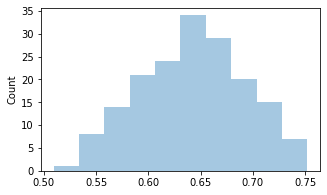

In [283]:
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(predicted_success, kde=False);
a3.set(ylabel='Count')

#### Tidy up data frame

In [284]:
# add predicted restaurant success column to data frame
LA_neigh_ratio['predicted_success'] = predicted_success

# change neighborhood column name from Vegan Venue to Borough
LA_neigh_ratio.rename(columns={"Vegan Venue": "Borough"}, inplace=True)

LA_neigh_ratio.head()

Borough  ATM  Academic Building  Accessories  Acupuncturist  \
0  Adams-Normandie  0.0                0.0     0.000000            0.0   
1         Alhambra  0.0                0.0     0.010101            0.0   
2         Altadena  0.0                0.0     0.000000            0.0   
3          Arcadia  0.0                0.0     0.000000            0.0   
4           Arleta  0.0                0.0     0.000000            0.0   

   Administrative Building  Adult Boutique  African  American  Amphitheater  \
0                      0.0             0.0      0.0       0.0           0.0   
1                      0.0             0.0      0.0       0.0           0.0   
2                      0.0             0.0      0.0       0.0           0.0   
3                      0.0             0.0      0.0       0.0           0.0   
4                      0.0             0.0      0.0       0.0           0.0   

   Antiques   Apparel    Arcade  Arepas  Argentinian  Art Gallery  Art Museum  \
0       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   
1       0.0  0.010101  0.010101     0.0          0.0          0.0         0.0   
2       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   
3       0.0  0.250000  0.000000     0.0          0.0          0.0         0.0   
4       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   

   Art Studio  Arts  Arts & Crafts  Arts & Entertainment     Asian  \
0         0.0   0.0       0.000000                   0.0  0.000000   
1         0.0   0.0       0.010101                   0.0  0.010101   
2         0.0   0.0       0.000000                   0.0  0.000000   
3         0.0   0.0       0.000000                   0.0  0.000000   
4         0.0   0.0       0.000000                   0.0  0.000000   

   Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
0              0.0         0.0         0.0          0.0          0.0   
1              0.0         0.0         0.0          0.0          0.0   
2              0.0         0.0         0.0          0.0          0.0   
3              0.0         0.0         0.0          0.0          0.0   
4              0.0         0.0         0.0          0.0          0.0   

   Auto Workshop  Automotive       BBQ  Baby Store  Bagels    Bakery  \
0            0.0    0.142857  0.000000         0.0     0.0  0.000000   
1            0.0    0.000000  0.010101         0.0     0.0  0.020202   
2            0.0    0.000000  0.000000         0.0     0.0  0.000000   
3            0.0    0.000000  0.000000         0.0     0.0  0.000000   
4            0.0    0.000000  0.000000         0.0     0.0  0.000000   

       Bank       Bar  Basketball  Beach Bar  Beer Bar  Beer Garden  \
0  0.000000  0.000000         0.0        0.0       0.0     0.000000   
1  0.020202  0.030303         0.0        0.0       0.0     0.010101   
2  0.000000  0.000000         0.0        0.0       0.0     0.000000   
3  0.000000  0.000000         0.0        0.0       0.0     0.000000   
4  0.000000  0.000000         0.0        0.0       0.0     0.000000   

   Beer Store  Betting Shop  Big Box Store  Bike Shop  Billiards  Bistro  \
0         0.0           0.0            0.0        0.0        0.0     0.0   
1         0.0           0.0            0.0        0.0        0.0     0.0   
2         0.0           0.0            0.0        0.0        0.0     0.0   
3         0.0           0.0            0.0        0.0        0.0     0.0   
4         0.0           0.0            0.0        0.0        0.0     0.0   

   Board Shop  Bookstore  Boutique  Bowling Alley  Brazilian  Breakfast  \
0         0.0   0.000000  0.000000            0.0        0.0   0.071429   
1         0.0   0.010101  0.030303            0.0        0.0   0.000000   
2         0.0   0.000000  0.000000            0.0        0.0   0.000000   
3         0.0   0.000000  0.000000            0.0        0.0   0.000000   
4         0.0   0.000000  0.000000            0.0        0

In [285]:
## attach latitude and longitude to boroughs/neighborhoods
df_neigh_pred_success = LA_neigh_ratio.merge(df_neigh[["Name","lat", "lng"]], left_on='Borough', right_on='Name')

## delete redundant "name" column
del df_neigh_pred_success['Name']
df_neigh_pred_success.head()

Borough  ATM  Academic Building  Accessories  Acupuncturist  \
0  Adams-Normandie  0.0                0.0     0.000000            0.0   
1         Alhambra  0.0                0.0     0.010101            0.0   
2         Altadena  0.0                0.0     0.000000            0.0   
3          Arcadia  0.0                0.0     0.000000            0.0   
4           Arleta  0.0                0.0     0.000000            0.0   

   Administrative Building  Adult Boutique  African  American  Amphitheater  \
0                      0.0             0.0      0.0       0.0           0.0   
1                      0.0             0.0      0.0       0.0           0.0   
2                      0.0             0.0      0.0       0.0           0.0   
3                      0.0             0.0      0.0       0.0           0.0   
4                      0.0             0.0      0.0       0.0           0.0   

   Antiques   Apparel    Arcade  Arepas  Argentinian  Art Gallery  Art Museum  \
0       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   
1       0.0  0.010101  0.010101     0.0          0.0          0.0         0.0   
2       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   
3       0.0  0.250000  0.000000     0.0          0.0          0.0         0.0   
4       0.0  0.000000  0.000000     0.0          0.0          0.0         0.0   

   Art Studio  Arts  Arts & Crafts  Arts & Entertainment     Asian  \
0         0.0   0.0       0.000000                   0.0  0.000000   
1         0.0   0.0       0.010101                   0.0  0.010101   
2         0.0   0.0       0.000000                   0.0  0.000000   
3         0.0   0.0       0.000000                   0.0  0.000000   
4         0.0   0.0       0.000000                   0.0  0.000000   

   Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
0              0.0         0.0         0.0          0.0          0.0   
1              0.0         0.0         0.0          0.0          0.0   
2              0.0         0.0         0.0          0.0          0.0   
3              0.0         0.0         0.0          0.0          0.0   
4              0.0         0.0         0.0          0.0          0.0   

   Auto Workshop  Automotive       BBQ  Baby Store  Bagels    Bakery  \
0            0.0    0.142857  0.000000         0.0     0.0  0.000000   
1            0.0    0.000000  0.010101         0.0     0.0  0.020202   
2            0.0    0.000000  0.000000         0.0     0.0  0.000000   
3            0.0    0.000000  0.000000         0.0     0.0  0.000000   
4            0.0    0.000000  0.000000         0.0     0.0  0.000000   

       Bank       Bar  Basketball  Beach Bar  Beer Bar  Beer Garden  \
0  0.000000  0.000000         0.0        0.0       0.0     0.000000   
1  0.020202  0.030303         0.0        0.0       0.0     0.010101   
2  0.000000  0.000000         0.0        0.0       0.0     0.000000   
3  0.000000  0.000000         0.0        0.0       0.0     0.000000   
4  0.000000  0.000000         0.0        0.0       0.0     0.000000   

   Beer Store  Betting Shop  Big Box Store  Bike Shop  Billiards  Bistro  \
0         0.0           0.0            0.0        0.0        0.0     0.0   
1         0.0           0.0            0.0        0.0        0.0     0.0   
2         0.0           0.0            0.0        0.0        0.0     0.0   
3         0.0           0.0            0.0        0.0        0.0     0.0   
4         0.0           0.0            0.0        0.0        0.0     0.0   

   Board Shop  Bookstore  Boutique  Bowling Alley  Brazilian  Breakfast  \
0         0.0   0.000000  0.000000            0.0        0.0   0.071429   
1         0.0   0.010101  0.030303            0.0        0.0   0.000000   
2         0.0   0.000000  0.000000            0.0        0.0   0.000000   
3         0.0   0.000000  0.000000            0.0        0.0   0.000000   
4         0.0   0.000000  0.000000            0.0        0

### Plot neighborhoods by how likely they are to support opening of a new restaurant (in their centre)

In [286]:
## Treating all vegan restaurants equally for now, let's explore ratings ... 
# create map 
latitude = 34.0330812
longitude = -118.204865
map_LA_neigh_suitable_for_vegans = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
df = df_neigh_pred_success
for lat, lng, neigh, success in zip(df['lat'], df['lng'], df['Borough'], df['predicted_success']):
    if success > 0.9:
        cur_col = 'green'
    elif success >= 0.8:
        cur_col = '#73cd32'#cdb332
    elif success >= 0.7:
        cur_col = '#9acd32'
    elif success >= 0.6:
        cur_col = '#c1cd32'
    elif success >= 0.5:
        cur_col = 'orange'
    else:
        cur_col = 'red'
    label = '{}'.format(neigh)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=folium.Popup(label, parse_html=True),
        color=cur_col,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_neigh_suitable_for_vegans)  
    
map_LA_neigh_suitable_for_vegans

Which locations are the 5 most promising?

In [287]:
## show dataframe rows for five largest predicted success values
df_neigh_pred_success.nlargest(5, "predicted_success", keep='first')

Borough       ATM  Academic Building  Accessories  Acupuncturist  \
92           Maywood  0.015625                0.0          0.0            0.0   
9    Avocado Heights  0.000000                0.0          0.0            0.0   
104          Pacoima  0.000000                0.0          0.0            0.0   
67     Hermosa Beach  0.000000                0.0          0.0            0.0   
41            Duarte  0.000000                0.0          0.0            0.0   

     Administrative Building  Adult Boutique  African  American  Amphitheater  \
92                       0.0             0.0      0.0  0.000000           0.0   
9                        0.0             0.0      0.0  0.000000           0.0   
104                      0.0             0.0      0.0  0.000000           0.0   
67                       0.0             0.0      0.0  0.015385           0.0   
41                       0.0             0.0      0.0  0.000000           0.0   

     Antiques   Apparel    Arcade  Arepas  Argentinian  Art Gallery  \
92   0.000000  0.015625  0.000000     0.0          0.0     0.000000   
9    0.000000  0.000000  0.000000     0.0          0.0     0.000000   
104  0.000000  0.000000  0.000000     0.0          0.0     0.071429   
67   0.015385  0.000000  0.015385     0.0          0.0     0.046154   
41   0.000000  0.000000  0.000000     0.0          0.0     0.000000   

     Art Museum  Art Studio  Arts  Arts & Crafts  Arts & Entertainment  \
92          0.0         0.0   0.0            0.0                   0.0   
9           0.0         0.0   0.0            0.0                   0.0   
104         0.0         0.0   0.0            0.0                   0.0   
67          0.0         0.0   0.0            0.0                   0.0   
41          0.0         0.0   0.0            0.0                   0.0   

        Asian  Assisted Living  Astrologer  Australian  Auto Dealer  \
92   0.015625              0.0         0.0         0.0     0.015625   
9    0.000000              0.0         0.0         0.0     0.000000   
104  0.000000              0.0         0.0         0.0     0.000000   
67   0.000000              0.0         0.0         0.0     0.000000   
41   0.015152              0.0         0.0         0.0     0.000000   

     Auto Garage  Auto Workshop  Automotive       BBQ  Baby Store    Bagels  \
92           0.0            0.0    0.062500  0.000000         0.0  0.000000   
9            0.0            0.0    0.538462  0.000000         0.0  0.000000   
104          0.0            0.0    0.214286  0.000000         0.0  0.071429   
67           0.0            0.0    0.000000  0.000000         0.0  0.000000   
41           0.0            0.0    0.030303  0.015152         0.0  0.000000   

       Bakery      Bank  Bar  Basketball  Beach Bar  Beer Bar  Beer Garden  \
92   0.015625  0.031250  0.0         0.0        0.0       0.0          0.0   
9    0.000000  0.000000  0.0         0.0        0.0       0.0          0.0   
104  0.000000  0.000000  0.0         0.0        0.0       0.0          0.0   
67   0.000000  0.030769  0.0         0.0        0.0       0.0          0.0   
41   0.015152  0.030303  0.0         0.0        0.0       0.0          0.0   

     Beer Store  Betting Shop  Big Box Store  Bike Shop  Billiards  Bistro  \
92          0.0           0.0       0.000000   0.000000        0.0     0.0   
9           0.0           0.0       0.000000   0.000000        0.0     0.0   
104         0.0           0.0       0.000000   0.000000        0.0     0.0   
67          0.0           0.0       0.000000   0.015385        0.0     0.0   
41          0.0           0.0       0.015152   0.000000        0.0     0.0   

     Board Shop  Bookstore  Boutique  Bowling Alley  Brazilian  Breakfast  \
92     0.000000        0.0       0.0            0.0        0.0   0.000000   
9      0.000000        0.0       0.0            0.0        0.0   0.000000   
104    0.000000        0.0       0.0            0.0        0.0   0.000000   
67     0.030769    

### Show best locations on Map:

In [295]:
# create map 
latitude = 34.0330812
longitude = -118.204865
map_LA_neigh_suitable_for_vegans = folium.Map(location=[latitude, longitude], zoom_start=10)

top_loc = list(df_neigh_pred_success.nlargest(5, "predicted_success", keep='first')['Borough'])

# add markers to map
df = df_neigh_pred_success
for lat, lng, neigh, success in zip(df['lat'], df['lng'], df['Borough'], df['predicted_success']):
    if success > 0.9:
        cur_col = 'green'
    elif success >= 0.8:
        cur_col = '#73cd32'#cdb332
    elif success >= 0.7:
        cur_col = '#9acd32'
    elif success >= 0.6:
        cur_col = '#c1cd32'
    elif success >= 0.5:
        cur_col = 'orange'
    else:
        cur_col = 'red'
    if neigh in top_loc:
        cur_col = 'green'
    label = '{}'.format(neigh)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=folium.Popup(label, parse_html=True),
        color=cur_col,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_neigh_suitable_for_vegans)  
    
map_LA_neigh_suitable_for_vegans

Now for the final test: Go through a subset of possible LA locations where we might want to open a vegan restaurant in a grid, i.e. in steps of 300 meters east to west and north to south and check surrounding venue characteristics to establish location suitability. 

### create coordinate grid over part of LA

In [ ]:
nlat = 34.02
slat = 33.98
wlng = -118.32
elng = -118.28

## Compute distance in meters between bounds (horizontally and vertically)
from geopy.distance import distance

dist_ew = distance((nlat,elng), (nlat,wlng)).m
dist_sn = distance((slat,elng), (nlat,elng)).m

print(dist_ew)
print(dist_sn)

In [ ]:
## if we want to take 300 m steps, we need to divide the difference between north & south and east & west coordinates into 
## this many steps:
steps_north = np.ceil(dist_sn / 300)
steps_west = np.ceil(dist_ew / 300)

## create grid
lats = np.linspace(start = slat, stop = nlat, num = steps_north) 
lngs = np.linspace(start = elng, stop = wlng, num = steps_west)

In [ ]:
## create dataframe columns / lists
lat = list()
lng = list()
for ilat in lats:
    for ilng in lngs:
        lat.append(ilat)
        lng.append(ilng)
        
df_grid = pd.DataFrame(list(zip(lat, lng)), columns =['lat', 'lng']) 

df_grid.shape

### Illustrate coordinate grid on map

In [643]:
## Show locations on map
latitude = 34.0330812
longitude = -118.204865
map_LA_grid = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
df = df_grid
for lat, lng in zip(df['lat'], df['lng']):
    label = '{}, {}'.format(lat, lng)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=folium.Popup(label, parse_html=True),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_grid)  
    
map_LA_grid

#### Get neighborhood information for each coordinate

In [644]:
LA_grid_venues = getNearbyVenues(df_grid.index, df_grid["lat"], df_grid["lng"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [645]:
LA_grid_venues.iloc[400:404,:]

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
400            95              33.988571             -118.256667   
401            95              33.988571             -118.256667   
402            95              33.988571             -118.256667   
403            95              33.988571             -118.256667   

                                    Venue                  Venue ID  \
400                   AutoZone Auto Parts  4b7b2b36f964a52089552fe3   
401                             Auto zone  4eb9d5cee300cf4cac071e00   
402  Cricket Wireless Authorized Retailer  53bad03d498e3a0a0d3d8228   
403                          L.A Nail Spa  56eee6cf498e4f224679a16d   

     Venue Latitude  Venue Longitude Venue Category Detailed  Venue Category  
400       33.988281      -118.256135              Automotive  Shop & Service  
401       33.988281      -118.256115              Automotive  Shop & Service  
402       33.988237      -118.257566           Mobile Phones  Shop & Service  
403       33.988055      -118.257279              Nail Salon  Shop & Service

One hot encoding of venues

In [646]:
# one hot encoding of venue categories by neighborhood
# LA_onehot = pd.get_dummies(surrounding_venues[['Venue Category']], prefix="", prefix_sep="")
LA_grid_onehot = pd.get_dummies(LA_grid_venues[['Venue Category Detailed']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_grid_onehot['Vegan Venue'] = LA_grid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_grid_onehot.columns[-1]] + list(LA_grid_onehot.columns[:-1])
LA_grid_onehot = LA_grid_onehot[fixed_columns]

LA_grid_onehot.head()

Vegan Venue  ATM  Academic Building  Accessories  Adult Boutique  African  \
0            0    0                  0            0               0        0   
1            0    0                  0            0               0        0   
2            2    0                  0            0               0        0   
3            2    0                  0            0               0        0   
4            2    0                  0            0               0        0   

   American  Amphitheater  Antiques  Apparel  Aquarium  Arcade  Art Gallery  \
0         0             0         0        0         0       0            0   
1         0             0         0        0         0       0            0   
2         0             0         0        0         0       0            0   
3         0             0         0        0         0       0            0   
4         0             0         0        0         0       0            0   

   Art Museum  Arts & Crafts  Arts & Entertainment  Asian  Auto Dealer  \
0           0              0                     0      0            0   
1           0              0                     0      0            0   
2           0              0                     0      0            0   
3           0              0                     0      0            0   
4           0              0                     0      0            0   

   Auto Garage  Auto Workshop  Automotive  BBQ  Bagels  Bakery  Bank  Bar  \
0            0              0           0    0       0       0     0    0   
1            0              0           0    0       0       0     0    0   
2            0              0           0    0       0       0     0    0   
3            0              0           0    0       0       0     0    0   
4            0              0           0    0       0       0     0    0   

   Basketball  Beer Garden  Big Box Store  Bike Shop  Billiards  Bookstore  \
0           0            0              0          0          0          0   
1           0            0              0          0          0          0   
2           0            0              0          0          0          0   
3           0            0              0          0          0          0   
4           0            0              0          0          0          0   

   Boutique  Bowling Alley  Breakfast  Buffet  Building  Burgers  Burritos  \
0         0              0          0       0         0        0         0   
1         0              0          0       0         0        0         0   
2         0              0          0       0         0        1         0   
3         0              0          0       0         0        0         0   
4         0              0          0       0         0        0         0   

   Bus Stop  Business Services  Butcher  Cafeteria  Café  Cajun / Creole  \
0         0                  0        0          0     0               0   
1         0                  0        0          0     0               0   
2         0                  0        0          0     0               0   
3         0                  0        0          0     0               0   
4         0                  0        0          0     0               0   

   Candy Store  Car Washes  Caribbean  Check Cashing Service  Chinese  \
0            0           0          0                      0        0   
1            0           0          0                      0        0   
2            0           0          0                      0        0   
3            0           0          0                      0        0   
4            0           0          0                      0        0   

   Cineplex  Cocktail  Coffee Shop  College Bookstore  Comedy Club  \
0         0         0            0                  0            0   
1         0         0            0                  0            0   
2         0         0            0                  0            0   
3         0         0    

Get proportion of surrounding venue type by vegan venue over all surrounding venues

In [647]:
## Data frame showing number of venue category by neighborhood
LA_grid_ratio = LA_grid_onehot.groupby('Vegan Venue').mean().reset_index()
#LA_grid_ratio = LA_grid_onehot.groupby('Vegan Venue').mean()
LA_grid_ratio.head()

Vegan Venue  ATM  Academic Building  Accessories  Adult Boutique  African  \
0            0  0.0                0.0          0.0             0.0      0.0   
1            2  0.0                0.0          0.0             0.0      0.0   
2            4  0.0                0.0          0.0             0.0      0.0   
3            5  0.0                0.0          0.0             0.0      0.0   
4            6  0.0                0.0          0.0             0.0      0.0   

   American  Amphitheater  Antiques  Apparel  Aquarium  Arcade  Art Gallery  \
0       0.0           0.0       0.0      0.0       0.0     0.0          0.0   
1       0.0           0.0       0.0      0.0       0.0     0.0          0.0   
2       0.0           0.0       0.0      0.0       0.0     0.0          0.2   
3       0.0           0.0       0.0      0.0       0.0     0.0          0.0   
4       0.0           0.0       0.0      0.0       0.0     0.0          0.0   

   Art Museum  Arts & Crafts  Arts & Entertainment  Asian  Auto Dealer  \
0         0.0            0.0                   0.0    0.0          0.0   
1         0.0            0.0                   0.0    0.0          0.0   
2         0.0            0.0                   0.0    0.0          0.0   
3         0.0            0.0                   0.0    0.0          0.0   
4         0.0            0.0                   0.0    0.0          0.0   

   Auto Garage  Auto Workshop  Automotive  BBQ  Bagels  Bakery  Bank  Bar  \
0          0.0            0.0    0.000000  0.0     0.0     0.0   0.0  0.0   
1          0.0            0.0    0.000000  0.0     0.0     0.0   0.0  0.0   
2          0.0            0.0    0.000000  0.0     0.0     0.0   0.2  0.0   
3          0.0            0.0    0.666667  0.0     0.0     0.0   0.0  0.0   
4          0.0            0.0    0.000000  0.0     0.0     0.0   0.0  0.0   

   Basketball  Beer Garden  Big Box Store  Bike Shop  Billiards  Bookstore  \
0         0.0          0.0            0.0        0.0        0.0        0.0   
1         0.0          0.0            0.0        0.0        0.0        0.0   
2         0.0          0.0            0.0        0.0        0.0        0.0   
3         0.0          0.0            0.0        0.0        0.0        0.0   
4         0.0          0.0            0.0        0.0        0.0        0.0   

   Boutique  Bowling Alley  Breakfast  Buffet  Building   Burgers  Burritos  \
0       0.0            0.0        0.0     0.0       0.0  0.000000       0.0   
1       0.0            0.0        0.0     0.0       0.0  0.166667       0.0   
2       0.0            0.0        0.0     0.0       0.0  0.000000       0.0   
3       0.0            0.0        0.0     0.0       0.0  0.000000       0.0   
4       0.0            0.0        0.0     0.0       0.0  0.000000       0.0   

   Bus Stop  Business Services   Butcher  Cafeteria  Café  Cajun / Creole  \
0       0.0                0.0  0.000000        0.0   0.0             0.0   
1       0.0                0.0  0.000000        0.0   0.0             0.0   
2       0.0                0.0  0.200000        0.0   0.0             0.0   
3       0.0                0.0  0.333333        0.0   0.0             0.0   
4       0.0                0.0  0.000000        0.0   0.0             0.0   

   Candy Store  Car Washes  Caribbean  Check Cashing Service  Chinese  \
0          0.0         0.0        0.0                    0.0      0.0   
1          0.0         0.0        0.0                    0.0      0.0   
2          0.0         0.0        0.0                    0.0      0.0   
3          0.0         0.0        0.0                    0.0      0.0   
4          0.0         0.0        0.0                    0.0      0.0   

   Cineplex  Cocktail  Coffee Shop  College Bookstore  Comedy Club  \
0       0.0       0.0          0.0                0.0          0.0   
1       0.0       0.0          0.0                0.0          0.0   
2       0.0       0.0          0.0                0.0          0.0   
3       0.0  

Retain latitude and longitude to add again later for plotting

In [648]:
geosp_coord = LA_grid_venues.drop_duplicates(keep='first', subset=["Neighborhood"])[["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"]]
#geosp_coord.reset_index(inplace=True)
geosp_coord.rename(columns={"Neighborhood": "Vegan Venue"}, inplace=True)
print(geosp_coord.shape)
geosp_coord.head()

(412, 3)


Vegan Venue  Neighborhood Latitude  Neighborhood Longitude
0             0                  33.98             -118.250000
2             2                  33.98             -118.256667
8             4                  33.98             -118.263333
13            5                  33.98             -118.266667
16            6                  33.98             -118.270000

Adjust test data to fit training data

In [649]:
## Add NaN-filled columns from training data if missing in test data   
LA_grid_ratio = LA_grid_ratio.align(LA_ratio, axis=1)[0]

## Delete test data columns that do not exist in training data
LA_grid_ratio = LA_grid_ratio.filter(list(LA_ratio.columns) , axis=1)

## fill NaNs with 0s (otherwise kNN does not run!)
LA_grid_ratio.fillna(0, inplace=True)

LA_grid_ratio.shape

(412, 399)

Add latitude and longitude columns again:

In [650]:
LA_grid_ratio = pd.merge(LA_grid_ratio, geosp_coord, on='Vegan Venue', how='outer')

In [651]:
LA_grid_ratio.rename(columns={"Neighborhood Latitude": "lat", "Neighborhood Longitude": "lng"}, inplace=True)

### Illustrate locations of interest on map

In [652]:
## Show locations on map
latitude = 34.02703703703704 
longitude = -118.25434782608696
map_LA_grid = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
df = LA_grid_ratio
for lat, lng in zip(df['lat'], df['lng']):
    label = '{}, {}'.format(lat, lng)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=folium.Popup(label, parse_html=True),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_grid)  
    
map_LA_grid

Delete locations with no surrounding venues

In [653]:
LA_grid_ratio = LA_grid_ratio[LA_grid_ratio.iloc[:,1:399].sum(axis=1) > 0]
LA_grid_ratio.shape

(411, 401)

Prepare data for kNN prediction

In [654]:
## Features (independent variables)
X_grid = LA_grid_ratio.drop(["Vegan Venue", "lat", "lng"], axis=1)

## standardize
Xz_grid = preprocessing.StandardScaler().fit(X_train).transform(X_grid)
Xz_grid[0:5]

array([[-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021],
       [-0.19564713, -0.06178021, -0.3275552 , ...,  0.        ,
        -0.36913668, -0.06178021]])

kNN regression

In [655]:
predicted_success=model.predict(Xz_grid) #make prediction on new data
predicted_success[0:5]

array([0.63069811, 0.71624459, 0.54752269, 0.5256008 , 0.64871515])

### Distribution of predicted restaurant success over all locations

[Text(0, 0.5, 'Count')]

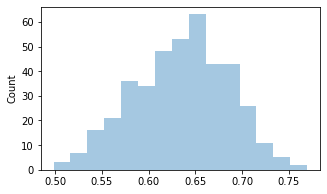

In [656]:
fig3,a3 = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
sns.distplot(predicted_success, kde=False);
a3.set(ylabel='Count')

In [657]:
# add predicted restaurant success column to data frame
LA_grid_ratio['predicted_success'] = predicted_success

LA_grid_ratio.head()

C:\Users\sbuer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Vegan Venue  ATM  Academic Building  Accessories  Acupuncturist  \
0            0  0.0                0.0          0.0            0.0   
1            2  0.0                0.0          0.0            0.0   
2            4  0.0                0.0          0.0            0.0   
3            5  0.0                0.0          0.0            0.0   
4            6  0.0                0.0          0.0            0.0   

   Administrative Building  Adult Boutique  African  American  Amphitheater  \
0                      0.0             0.0      0.0       0.0           0.0   
1                      0.0             0.0      0.0       0.0           0.0   
2                      0.0             0.0      0.0       0.0           0.0   
3                      0.0             0.0      0.0       0.0           0.0   
4                      0.0             0.0      0.0       0.0           0.0   

   Antiques  Apparel  Arcade  Arepas  Argentinian  Art Gallery  Art Museum  \
0       0.0      0.0     0.0     0.0          0.0          0.0         0.0   
1       0.0      0.0     0.0     0.0          0.0          0.0         0.0   
2       0.0      0.0     0.0     0.0          0.0          0.2         0.0   
3       0.0      0.0     0.0     0.0          0.0          0.0         0.0   
4       0.0      0.0     0.0     0.0          0.0          0.0         0.0   

   Art Studio  Arts  Arts & Crafts  Arts & Entertainment  Asian  \
0         0.0   0.0            0.0                   0.0    0.0   
1         0.0   0.0            0.0                   0.0    0.0   
2         0.0   0.0            0.0                   0.0    0.0   
3         0.0   0.0            0.0                   0.0    0.0   
4         0.0   0.0            0.0                   0.0    0.0   

   Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
0              0.0         0.0         0.0          0.0          0.0   
1              0.0         0.0         0.0          0.0          0.0   
2              0.0         0.0         0.0          0.0          0.0   
3              0.0         0.0         0.0          0.0          0.0   
4              0.0         0.0         0.0          0.0          0.0   

   Auto Workshop  Automotive  BBQ  Baby Store  Bagels  Bakery  Bank  Bar  \
0            0.0    0.000000  0.0         0.0     0.0     0.0   0.0  0.0   
1            0.0    0.000000  0.0         0.0     0.0     0.0   0.0  0.0   
2            0.0    0.000000  0.0         0.0     0.0     0.0   0.2  0.0   
3            0.0    0.666667  0.0         0.0     0.0     0.0   0.0  0.0   
4            0.0    0.000000  0.0         0.0     0.0     0.0   0.0  0.0   

   Basketball  Beach Bar  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0         0.0        0.0       0.0          0.0         0.0           0.0   
1         0.0        0.0       0.0          0.0         0.0           0.0   
2         0.0        0.0       0.0          0.0         0.0           0.0   
3         0.0        0.0       0.0          0.0         0.0           0.0   
4         0.0        0.0       0.0          0.0         0.0           0.0   

   Big Box Store  Bike Shop  Billiards  Bistro  Board Shop  Bookstore  \
0            0.0        0.0        0.0     0.0         0.0        0.0   
1            0.0        0.0        0.0     0.0         0.0        0.0   
2            0.0        0.0        0.0     0.0         0.0        0.0   
3            0.0        0.0        0.0     0.0         0.0        0.0   
4            0.0        0.0        0.0     0.0         0.0        0.0   

   Boutique  Bowling Alley  Brazilian  Breakfast  Brewery  Bridal  Bubble Tea  \
0       0.0            0.0        0.0        0.0      0.0     0.0         0.0   
1       0.0            0.0        0.0        0.0      0.0     0.0         0.0   
2       0.0            0.0        0.0        0.0      0.0     0.0         0.0   
3       0.0            0.0        0.0        0.0      0.0     0.0         0.0   
4       0.0            0.0        0.0 

In [658]:
## show dataframe rows for five largest predicted success values
df_grid_pred_success = LA_grid_ratio
df_grid_pred_success.nlargest(5, "predicted_success", keep='first')

Vegan Venue  ATM  Academic Building  Accessories  Acupuncturist  \
251          287  0.0                0.0          0.0            0.0   
280          318  0.0                0.0          0.0            0.0   
384          436  0.0                0.0          0.0            0.0   
153          176  0.0                0.0          0.0            0.0   
333          375  0.0                0.0          0.0            0.0   

     Administrative Building  Adult Boutique  African  American  Amphitheater  \
251                      0.0             0.0      0.0       0.0           0.0   
280                      0.0             0.0      0.0       0.0           0.0   
384                      0.0             0.0      0.0       0.0           0.0   
153                      0.0             0.0      0.0       0.0           0.0   
333                      0.0             0.0      0.0       0.0           0.0   

     Antiques  Apparel    Arcade  Arepas  Argentinian  Art Gallery  \
251       0.0      0.0  0.000000     0.0          0.0          0.0   
280       0.0      0.0  0.000000     0.0          0.0          0.0   
384       0.0      0.0  0.000000     0.0          0.0          0.0   
153       0.0      0.0  0.076923     0.0          0.0          0.0   
333       0.0      0.0  0.000000     0.0          0.0          0.0   

     Art Museum  Art Studio  Arts  Arts & Crafts  Arts & Entertainment  Asian  \
251         0.0         0.0   0.0            0.0                   0.0    0.0   
280         0.0         0.0   0.0            0.0                   0.0    0.0   
384         0.0         0.0   0.0            0.0                   0.0    0.0   
153         0.0         0.0   0.0            0.0                   0.0    0.0   
333         0.0         0.0   0.0            0.0                   0.0    0.0   

     Assisted Living  Astrologer  Australian  Auto Dealer  Auto Garage  \
251              0.0         0.0         0.0          0.0          0.0   
280              0.0         0.0         0.0          0.0          0.0   
384              0.0         0.0         0.0          0.0          0.0   
153              0.0         0.0         0.0          0.0          0.0   
333              0.0         0.0         0.0          0.0          0.0   

     Auto Workshop  Automotive  BBQ  Baby Store  Bagels    Bakery  Bank  Bar  \
251            0.0    0.333333  0.0         0.0     0.0  0.000000   0.0  0.0   
280            0.0    0.062500  0.0         0.0     0.0  0.125000   0.0  0.0   
384            0.0    0.000000  0.0         0.0     0.0  0.066667   0.0  0.0   
153            0.0    0.000000  0.0         0.0     0.0  0.000000   0.0  0.0   
333            0.0    0.000000  0.0         0.0     0.0  0.000000   0.0  0.0   

     Basketball  Beach Bar  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
251         0.0        0.0       0.0          0.0         0.0           0.0   
280         0.0        0.0       0.0          0.0         0.0           0.0   
384         0.0        0.0       0.0          0.0         0.0           0.0   
153         0.0        0.0       0.0          0.0         0.0           0.0   
333         0.0        0.0       0.0          0.0         0.0           0.0   

     Big Box Store  Bike Shop  Billiards  Bistro  Board Shop  Bookstore  \
251            0.0   0.000000        0.0     0.0         0.0        0.0   
280            0.0   0.000000        0.0     0.0         0.0        0.0   
384            0.0   0.066667        0.0     0.0         0.0        0.0   
153            0.0   0.000000        0.0     0.0         0.0        0.0   
333            0.0   0.000000        0.0     0.0         0.0        0.0   

     Boutique  Bowling Alley  Brazilian  Breakfast  Brewery  Bridal  \
251       0.0            0.0        0.0        0.0      0.0     0.0   
280       0.0            0.0        0.0        0.0      0.0     0.0   
384       0.0            0.0        0.0        0.0      0.0     0.0   
153       0.0            0.0        0.0  

### Show predicted restaurant success for each test location

In [662]:
# create map 
latitude = 34.0330812
longitude = -118.204865
map_LA_grid_suitable_for_vegans = folium.Map(location=[latitude, longitude], zoom_start=12)

top_loc = list(df_grid_pred_success.nlargest(5, "predicted_success", keep='first')['Vegan Venue'])

# add markers to map
df = df_grid_pred_success
for lat, lng, neigh, success in zip(df['lat'], df['lng'], df['Vegan Venue'], df['predicted_success']):
    if success > 0.9:
        cur_col = 'green'
    elif success >= 0.8:
        cur_col = '#73cd32'#cdb332
    elif success >= 0.7:
        cur_col = '#9acd32'
    elif success >= 0.6:
        cur_col = '#c1cd32'
    elif success >= 0.5:
        cur_col = 'orange'
    else:
        cur_col = 'red'
    if neigh in top_loc:
        cur_col = 'green'
    label = '{}, {}'.format(lat, lng)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=folium.Popup(label, parse_html=True),
        color=cur_col,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_grid_suitable_for_vegans)  
    
map_LA_grid_suitable_for_vegans

## Results and Discussion <a name="results"></a>

We explored the distribution of vegan restaurants/venues in the greater LA area and trained a k-nearest neighbor regressor to predict restaurant success based on the surroundings of a potential new venue. To this end we combined the venue ratings and likes into a measure of restaurant success. While this worked at face value, the results have to be interpreted with caution.

While there are more than 300 vegan venues in the greater LA area, few of them are likely to be pure vegan restaurants. For example, 140 venues were categorized as coffee shop. It is unlikely that the same neighborhood characteristics that lead to prosperity for a coffee shop are similarly effective for an Indian restaurant. 

Italian cuisine had the overall highest success rating and is a good choice, although an interesting follow up question would be whether or not these restaurants are purely vegan or only serve vegan food. Unfortunately, even though the Foursquare API allows for food menu requests, most restaurants do not provide it. 

It would be interesting to explore a larger dataset over multiple cities with a more fine grained definition of "how vegan" a restaurant actually is (e.g. from 0 vegan options to only serving vegan food), but that is beyond the scope of this project. 

## Conclusion <a name="conclusion"></a>

The main takeaway from this project is that while vegan restaurants and the offering of vegan options on a restaurant's menu are on the rise, there are still relatively few purely vegan venues (as seen by how few restaurants fall in the "vegetarian / vegan" category on Foursquare). Nevertheless, we could predict promising locations for new "vegan" restaurants in LA, albeit somewhat uncertain what "vegan" in this particular case actually means. 

A larger effort using data from multiple cities and discerning neighborhood characteristics more carefully (e.g. assessing foot traffic, proximity to metro stations etc.) will undoubtably lead to more informative results. Whether it is worth the time and effort is for the stakeholders to decide. 